# Example 1 - Square Ice Shelf

This notebook models a very simple Square Ice Shelf and is intended to provide a simple example of building an ISSM model using pyISSM.


In [1]:
import sys
sys.path.append('/Users/lawrence.bird/pyISSM/src/')
import pyissm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Create an empty model
md = pyissm.model.Model()

---
## 1. Model Mesh

### Build the mesh

In [3]:
# Create a mesh using the triangle meshing tool
md = pyissm.model.mesh.triangle(md,
                                domain_name = './assets/Exp/square_ice_shelf/DomainOutline.exp',
                                resolution = 100000)

# Inspect the created mesh
md.mesh

   2D tria Mesh (horizontal):
      Elements and vertices:
         numberofelements       : 148             -- number of elements
         numberofvertices       : 91              -- number of vertices
         elements               : (148, 3)        -- vertex indices of the mesh elements
         x                      : (91,)           -- vertices x coordinate [m]
         y                      : (91,)           -- vertices y coordinate [m]
         edges                  : N/A             -- edges of the 2d mesh (vertex1 vertex2 element1 element2)
         numberofedges          : 0               -- number of edges of the 2d mesh

      Properties:
         vertexonboundary       : (91,)           -- vertices on the boundary of the domain flag list
         segments               : (32, 3)         -- edges on domain boundary (vertex1 vertex2 element)
         segmentmarkers         : (32,)           -- number associated to each segment
         vertexconnectivity     : (91, 101) 

### Visualize the mesh

Text(0.5, 1.0, 'Square Ice Shelf Mesh')

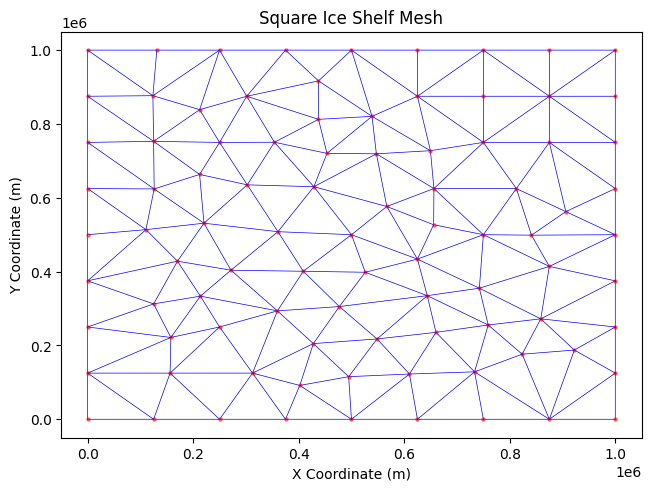

In [4]:
# Process the mesh for plotting
mesh, meshX, meshY, meshElements, is3d = pyissm.model.mesh.process_mesh(md)

# Plot the mesh with customised options
fig, ax = pyissm.plot.plot_mesh2d(mesh,
                                  color = 'blue',
                                  linewidth = 0.5,
                                  show_nodes = True,
                                  node_kwargs = {'s': 20,
                                                 'color': 'red',
                                                 'alpha': 0.5})
# We can interact with the plot using matplotlib functions
ax.set_xlabel('X Coordinate (m)')
ax.set_ylabel('Y Coordinate (m)')
ax.set_title('Square Ice Shelf Mesh')

---
## 2. Model Mask

### Define the mask
The `md.mask.ice_levelset` and `md.mask.ocean_levelset` fields interact to define where there is grounded ice, floating ice, ice-free regions, and open ocean within the model domain. In this example, the entire domain is floating ice. We can use the `set_mask()` function to efficiently define the `md.mask` fields.

In [5]:
# Define the mask: all ice is floating
md = pyissm.model.param.set_mask(md,
                                 floating_ice_name = 'all',
                                 grounded_ice_name = None)

# Inspect the mask
md.mask

   mask parameters:
         ice_levelset           : (91,)           -- presence of ice if < 0, icefront position if = 0, no ice if > 0
         ocean_levelset         : (91,)           -- presence of ocean if < 0, coastline/grounding line if = 0, no ocean if > 0

### Visualise the mask

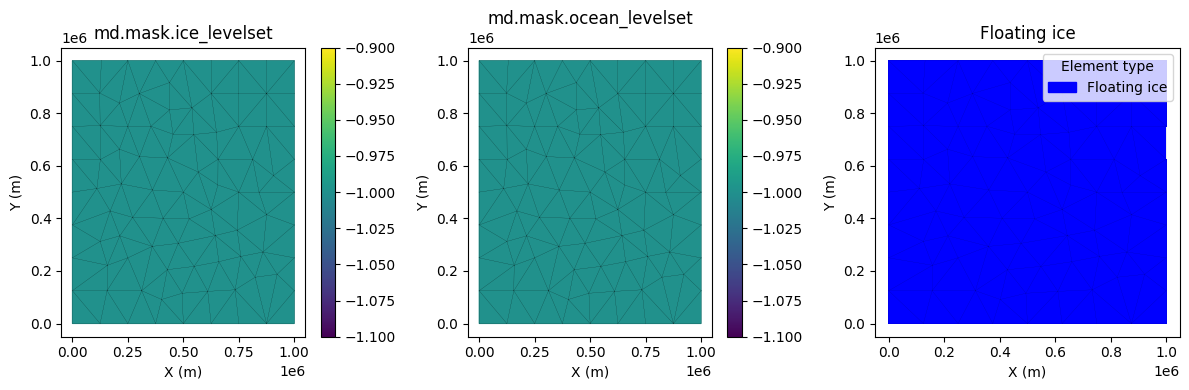

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
pyissm.plot.plot_model_field(md,
                             md.mask.ice_levelset,
                             show_cbar = True,
                             show_mesh = True,
                             ax = ax1)
ax1.set_title('md.mask.ice_levelset')

pyissm.plot.plot_model_field(md,
                             md.mask.ocean_levelset,
                             show_cbar = True,
                             show_mesh = True,
                             ax = ax2)
ax2.set_title('md.mask.ocean_levelset')

pyissm.plot.plot_model_elements(md,
                                ice_levelset = md.mask.ice_levelset,
                                ocean_levelset = md.mask.ocean_levelset,
                                type = 'floating_ice_elements',
                                show_mesh = True,
                                ax = ax3)
ax3.set_title('Floating ice')
plt.tight_layout()

---
## 3. Parameterise the model

<div class="alert alert-block alert-warning">
<b>pyissm.model.param.parameterize():</b> The following blocks of code used to parameterise the model can be embedded into a separate python file, and parsed to the model using:

<pre><code>md = pyissm.model.param.parameterize('PARAM_FILE.py')</code></pre>
 
This functions **exactly** the same as running the code directly, but helps to keep your main model execution scripts clean. We embed the code directly here for transparency.
</div>

### Define model geometry

In [7]:
# Define constants
hmin = 300
hmax = 1000
ymin = np.nanmin(md.mesh.y)
ymax = np.nanmax(md.mesh.y)

# Assign geometry to the model
md.geometry.thickness = hmax + (hmin - hmax) * (md.mesh.y - ymin) / (ymax - ymin)
md.geometry.base = - md.materials.rho_ice / md.materials.rho_water * md.geometry.thickness
md.geometry.surface = md.geometry.base + md.geometry.thickness

# Inspect the geometry
md.geometry

   geometry parameters:
         surface                : (91,)           -- ice upper surface elevation [m]
         thickness              : (91,)           -- ice thickness [m]
         base                   : (91,)           -- ice base elevation [m]
         bed                    : N/A             -- bed elevation [m]
         hydrostatic_ratio      : N/A             -- hydrostatic ratio for floating ice

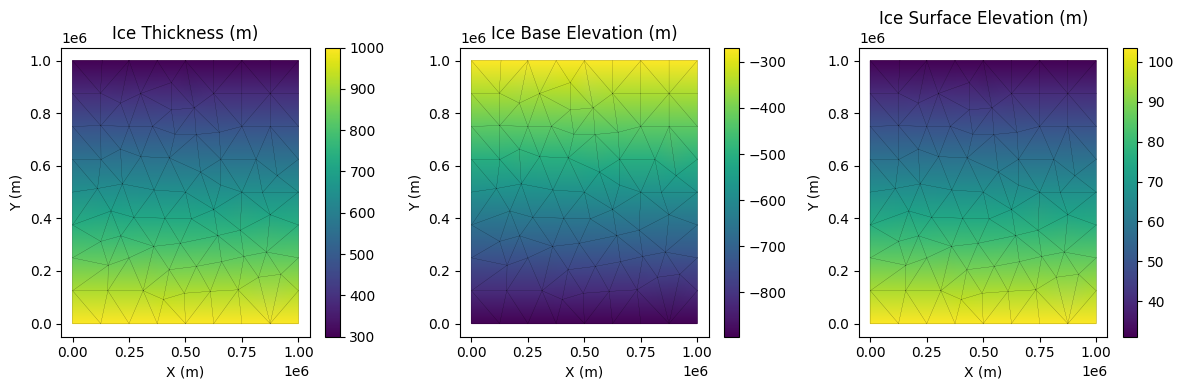

In [8]:
# Visualise the model geometry
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
pyissm.plot.plot_model_field(md,
                             md.geometry.thickness,
                             show_cbar = True,
                             show_mesh = True,
                             ax = ax1)
ax1.set_title('Ice Thickness (m)')

pyissm.plot.plot_model_field(md,
                             md.geometry.base,
                             show_cbar = True,
                             show_mesh = True,
                             ax = ax2)
ax2.set_title('Ice Base Elevation (m)')

pyissm.plot.plot_model_field(md,
                             md.geometry.surface,
                             show_cbar = True,
                             show_mesh = True,
                             ax = ax3)
ax3.set_title('Ice Surface Elevation (m)')
plt.tight_layout()

### Define friction

In [9]:
# Define friction parameters
md.friction.coefficient = np.where(md.mask.ocean_levelset < 0., 0, 200)
md.friction.p = np.ones((md.mesh.numberofelements))
md.friction.q = np.ones((md.mesh.numberofelements))

# Inspect friction parameters
md.friction

Basal shear stress parameters: Sigma_b = coefficient^2 * Neff ^r * |u_b|^(s - 1) * u_b,
(effective stress Neff = rho_ice * g * thickness + rho_water * g * base, r = q / p and s = 1 / p)
         coefficient            : (91,)           -- friction coefficient [SI]
         p                      : (148,)          -- p exponent
         q                      : (148,)          -- q exponent
         coupling               : 0               -- Coupling flag 0: uniform sheet (negative pressure ok, default), 1: ice pressure only, 2: water pressure assuming uniform sheet (no negative pressure), 3: use provided effective_pressure, 4: used coupled model (not implemented yet)
         linearize              : 0               -- 0: not linearized, 1: interpolated linearly, 2: constant per element (default is 0)
         effective_pressure     : N/A             -- Effective Pressure for the forcing if not coupled [Pa]
         effective_pressure_l...: 0               -- Neff do not allow to fall

/Users/lawrence.bird/pyISSM/src/pyissm/plot.py:514: UserWarning: Using plot_data_on = 'elements'. Data are defined on elements
  warnings.warn("Using plot_data_on = 'elements'. Data are defined on elements")


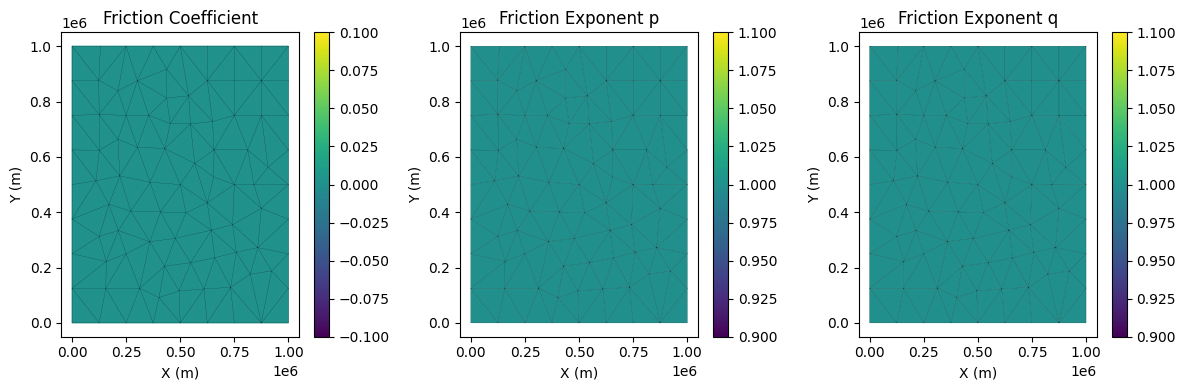

In [10]:
# Visualise the friction fields
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
pyissm.plot.plot_model_field(md,
                             md.friction.coefficient,
                             show_cbar = True,
                             show_mesh = True,
                             ax = ax1)
ax1.set_title('Friction Coefficient')

pyissm.plot.plot_model_field(md,
                             md.friction.p,
                             show_cbar = True,
                             show_mesh = True,
                             ax = ax2)
ax2.set_title('Friction Exponent p')

pyissm.plot.plot_model_field(md,
                             md.friction.q,
                             show_cbar = True,
                             show_mesh = True,
                             ax = ax3)
ax3.set_title('Friction Exponent q')
plt.tight_layout()

### Define initial velocity

In [11]:
# Define initial velocities
md.initialization.vx = np.zeros((md.mesh.numberofvertices))
md.initialization.vy = np.zeros((md.mesh.numberofvertices))
md.initialization.vz = np.zeros((md.mesh.numberofvertices))
md.initialization.vel = np.zeros((md.mesh.numberofvertices))

# Inspect initialization fields
md.initialization

   initial field values:
         vx                     : (91,)           -- x component of velocity [m/yr]
         vy                     : (91,)           -- y component of velocity [m/yr]
         vz                     : (91,)           -- z component of velocity [m/yr]
         vel                    : (91,)           -- velocity norm [m/yr]
         pressure               : N/A             -- pressure [Pa]
         temperature            : N/A             -- temperature [K]
         enthalpy               : N/A             -- enthalpy [J]
         waterfraction          : N/A             -- fraction of water in the ice
         watercolumn            : N/A             -- thickness of subglacial water [m]
         sediment_head          : N/A             -- sediment water head of subglacial system [m]
         epl_head               : N/A             -- epl water head of subglacial system [m]
         epl_thickness          : N/A             -- thickness of the epl [m]
         

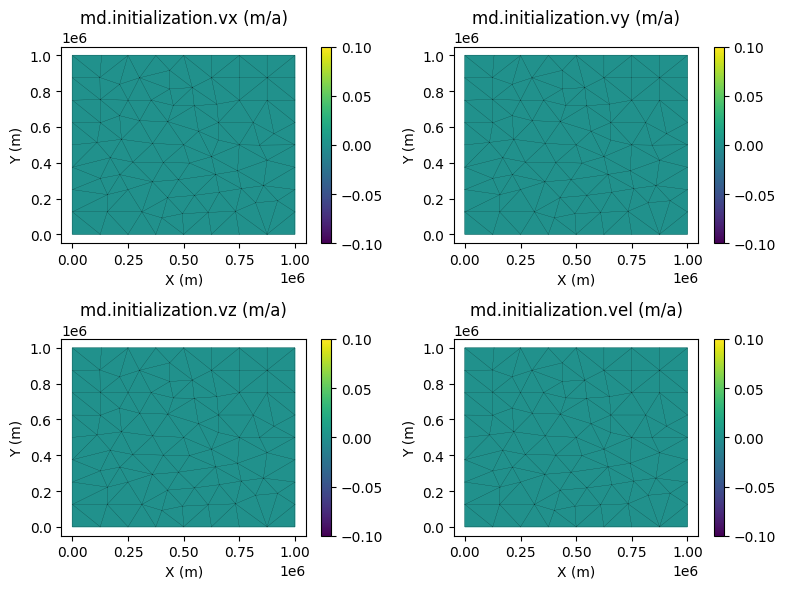

In [12]:
# Visualise the initial velocities
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))
pyissm.plot.plot_model_field(md,
                             md.initialization.vx,
                             show_cbar = True,
                             show_mesh = True,
                             ax = ax1)
ax1.set_title('md.initialization.vx (m/a)')
pyissm.plot.plot_model_field(md,
                             md.initialization.vy,
                             show_cbar = True,
                             show_mesh = True,
                             ax = ax2)
ax2.set_title('md.initialization.vy (m/a)')
pyissm.plot.plot_model_field(md,
                             md.initialization.vz,
                             show_cbar = True,
                             show_mesh = True,
                             ax = ax3)
ax3.set_title('md.initialization.vz (m/a)')
pyissm.plot.plot_model_field(md,
                             md.initialization.vel,
                             show_cbar = True,
                             show_mesh = True,
                             ax = ax4)
ax4.set_title('md.initialization.vel (m/a)')
plt.tight_layout()


### Define flow law parameters

In [13]:
# Define materials parameters
md.materials.rheology_B = pyissm.tools.materials.paterson((273 - 20) * np.ones((md.mesh.numberofvertices)))
md.materials.rheology_n = 3 * np.ones((md.mesh.numberofelements))

# Inspect the materials parameters
md.materials

   Materials (ice):
         rho_ice                : 917.0           -- ice density [kg/m^3]
         rho_water              : 1023.0          -- ocean water density [kg/m^3]
         rho_freshwater         : 1000.0          -- fresh water density [kg/m^3]
         mu_water               : 0.001787        -- water viscosity [N s/m^2]
         heatcapacity           : 2093.0          -- heat capacity [J/kg/K]
         thermalconductivity    : 2.4             -- ice thermal conductivity [W/m/K]
         temperateiceconducti...: 0.24            -- temperate ice thermal conductivity [W/m/K]
         meltingpoint           : 273.15          -- melting point of ice at 1atm in K
         latentheat             : 334000.0        -- latent heat of fusion [J/m^3]
         beta                   : 9.8e-08         -- rate of change of melting point with pressure [K/Pa]
         mixed_layer_capacity   : 3974.0          -- mixed layer capacity [W/kg/K]
         thermal_exchange_vel...: 0.0001      

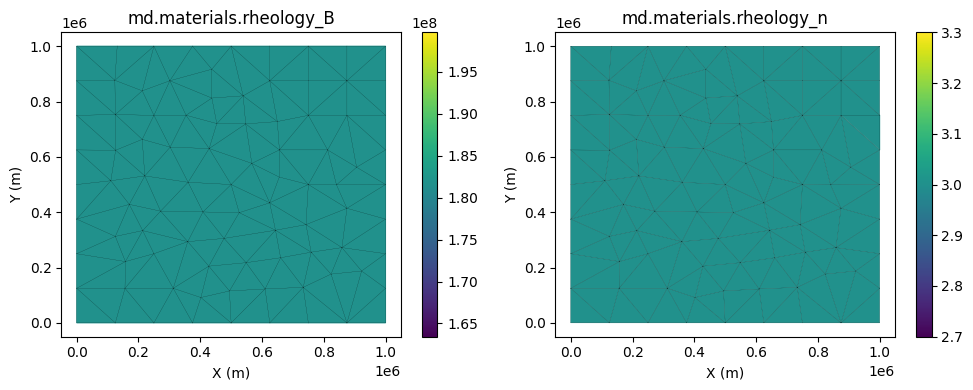

In [14]:
# Visualise materials parameters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
pyissm.plot.plot_model_field(md,
                             md.materials.rheology_B,
                             show_cbar = True,
                             show_mesh = True,
                             ax = ax1)
ax1.set_title('md.materials.rheology_B')

pyissm.plot.plot_model_field(md,
                             md.materials.rheology_n,
                             show_cbar = True,
                             show_mesh = True,
                             ax = ax2)
ax2.set_title('md.materials.rheology_n')
plt.tight_layout()

### Define boundary conditions

By default, we set Dirichlet boundary conditions on all inflow nodes and Neumann boundary conditions at the ice-front.

In [15]:
# Set ice shelf boundary conditions.
md = pyissm.model.bc.set_ice_shelf_bc(md, './assets/Exp/square_ice_shelf/Front.exp')

# Inspect boundary conditions
# Stress balance boundary conditions are defined by combination of fields in md.stressbalance.spcvx, md.stressbalance.spcvy, md.stressbalance.spcvz.
md.stressbalance

/Users/lawrence.bird/pyISSM/src/pyissm/model/bc.py:101: UserWarning: pyissm.model.bc.set_sb_dirichlet_bc: No observed velocities found. Setting stressbalance model boundary conditions as 0.
  warnings.warn('pyissm.model.bc.set_sb_dirichlet_bc: No observed velocities found. Setting stressbalance model boundary conditions as 0.')
/Users/lawrence.bird/pyISSM/src/pyissm/model/classes/smb.py:114: UserWarning: pyissm.model.classes.smb.default: smb.mass_balance not specified -- set to 0.
  warnings.warn('pyissm.model.classes.smb.default: smb.mass_balance not specified -- set to 0.')
/Users/lawrence.bird/pyISSM/src/pyissm/model/classes/basalforcings.py:116: UserWarning: pyissm.model.classes.basalforcings.default: no groundedice_melting_rate specified -- values set as 0
  warnings.warn('pyissm.model.classes.basalforcings.default: no groundedice_melting_rate specified -- values set as 0')
/Users/lawrence.bird/pyISSM/src/pyissm/model/classes/basalforcings.py:120: UserWarning: pyissm.model.classes

   StressBalance solution parameters:
      Convergence criteria:
         restol                 : 0.0001          -- mechanical equilibrium residual convergence criterion
         reltol                 : 0.01            -- velocity relative convergence criterion, NaN: not applied
         abstol                 : 10              -- velocity absolute convergence criterion, NaN: not applied
         isnewton               : 0               -- 0: Picard's fixed point, 1: Newton's method, 2: hybrid
         maxiter                : 100             -- maximum number of nonlinear iterations

      boundary conditions:
         spcvx                  : (91,)           -- x-axis velocity constraint (NaN means no constraint) [m / yr]
         spcvy                  : (91,)           -- y-axis velocity constraint (NaN means no constraint) [m / yr]
         spcvz                  : (91,)           -- z-axis velocity constraint (NaN means no constraint) [m / yr]

      MOLHO boundary conditions

Text(0.5, 1.0, 'Ice Shelf Boundary Conditions')

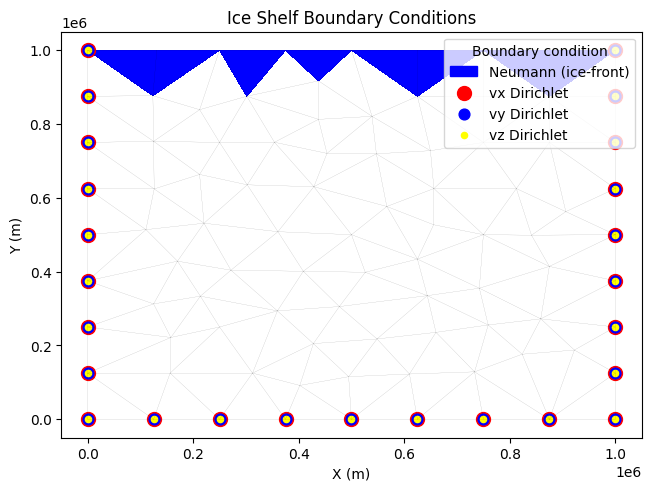

In [16]:
# Visualise boundary conditions
fig, ax = pyissm.plot.plot_model_bc(md)
ax.set_title('Ice Shelf Boundary Conditions')

---
## 4. Set the flow equation

Here, we use the Shelfy-Stream Approximation (SSA) of the Full-Stokes equation across the whole domain.

In [17]:
# Use the SSA flow approximation across the whole domain
md = pyissm.model.param.set_flow_equation(md, SSA = 'all')

## 5. Execute the model

Here, we run the model! We use the default `md.cluster` as we can run this small model on a Gadi login node. For larger mdoels, we'd need to change the cluster to use `pyissm.model.classes.cluster.gadi()` and define various parameters here.

Here, the results are loaded back onto `md.results` once the model run has finished.

In [ ]:
# Give the model a name
md.miscellaneous.name = 'square_ice_shelf'

# Solve the stress balance
md = pyissm.model.execute.solve(md, 'Stressbalance')

Checking model consistency...
Marshalling for square_ice_shelf.bin
Uploading files to cluster...


/Users/lawrence.bird/pyISSM/src/pyissm/model/classes/qmu.py:95: UserWarning: pyissm.model.classes.qmu::qmu not yet implemented. Turning off qmu.
  warnings.warn('pyissm.model.classes.qmu::qmu not yet implemented. Turning off qmu.')


Transferring square_ice_shelf-01-20-2026-13-49-07-56621.tar.gz to cluster nri-088478...
Launching job square_ice_shelf on cluster nri-088478...

Ice-sheet and Sea-level System Model (ISSM) version  4.24
(website: http://issm.jpl.nasa.gov forum: https://issm.ess.uci.edu/forum/)

call computational core:
   computing new velocity
write lock file:

   FemModel initialization elapsed time:   0.004228
   Total Core solution elapsed time:       0.02331
   Linear solver elapsed time:             0.010665 (46%)

   Total elapsed time: 0 hrs 0 min 0 sec
Waiting for job to complete...
wait_on_lock not implemented yet
Job completed -- loading results from cluster...
Retrieving results from cluster nri-088478...


    StressbalanceSolution: [1x1 array]

### 6. Visualise the model results

Text(0.5, 1.0, 'Square Ice Shelf Velocity Field')

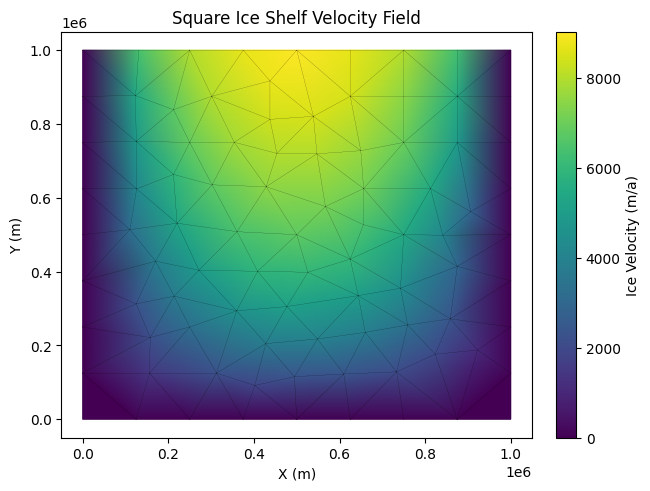

In [ ]:
# Visualise the resultant velocity field
fig, ax = pyissm.plot.plot_model_field(md,
                                       field = md.results.StressbalanceSolution.Vel,
                                       show_cbar = True,
                                       cbar_kwargs={'label': 'Ice Velocity (m/a)'},
                                       show_mesh = True)
ax.set_title('Square Ice Shelf Velocity Field')